In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
data_train = pd.read_csv("ntut-ml-regression-2021/train-v3.csv")
data_valid = pd.read_csv("ntut-ml-regression-2021/valid-v3.csv")
data_test = pd.read_csv("ntut-ml-regression-2021/test-v3.csv")
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

data_all = pd.concat([data_train, data_valid])

(12967, 23)
(2161, 23)
(6485, 22)


In [3]:
num_data=data_all.select_dtypes(['int64','float64'])
describe_num=data_all.describe().transpose()
print (describe_num)

                 count          mean           std           min  \
id             15128.0  4.586499e+09  2.877098e+09  1.000102e+06   
price          15128.0  5.362517e+05  3.635529e+05  7.500000e+04   
sale_yr        15128.0  2.014324e+03  4.681031e-01  2.014000e+03   
sale_month     15128.0  6.565375e+00  3.113648e+00  1.000000e+00   
sale_day       15128.0  1.574471e+01  8.635169e+00  1.000000e+00   
bedrooms       15128.0  3.363829e+00  9.375801e-01  0.000000e+00   
bathrooms      15128.0  2.108226e+00  7.676923e-01  0.000000e+00   
sqft_living    15128.0  2.070152e+03  9.166660e+02  2.900000e+02   
sqft_lot       15128.0  1.489898e+04  3.820881e+04  5.720000e+02   
floors         15128.0  1.441764e+00  5.526844e-01  1.000000e+00   
waterfront     15128.0  7.866208e-03  8.834505e-02  0.000000e+00   
view           15128.0  2.342015e-01  7.693312e-01  0.000000e+00   
condition      15128.0  3.413934e+00  6.518679e-01  1.000000e+00   
grade          15128.0  7.643707e+00  1.166838e+

/tmp/ipykernel_258716/4055261699.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_data[name].dropna()).set_title(name)
/tmp/ipykernel_258716/4055261699.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)
/tmp/ipykernel_258716/4055261699.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For

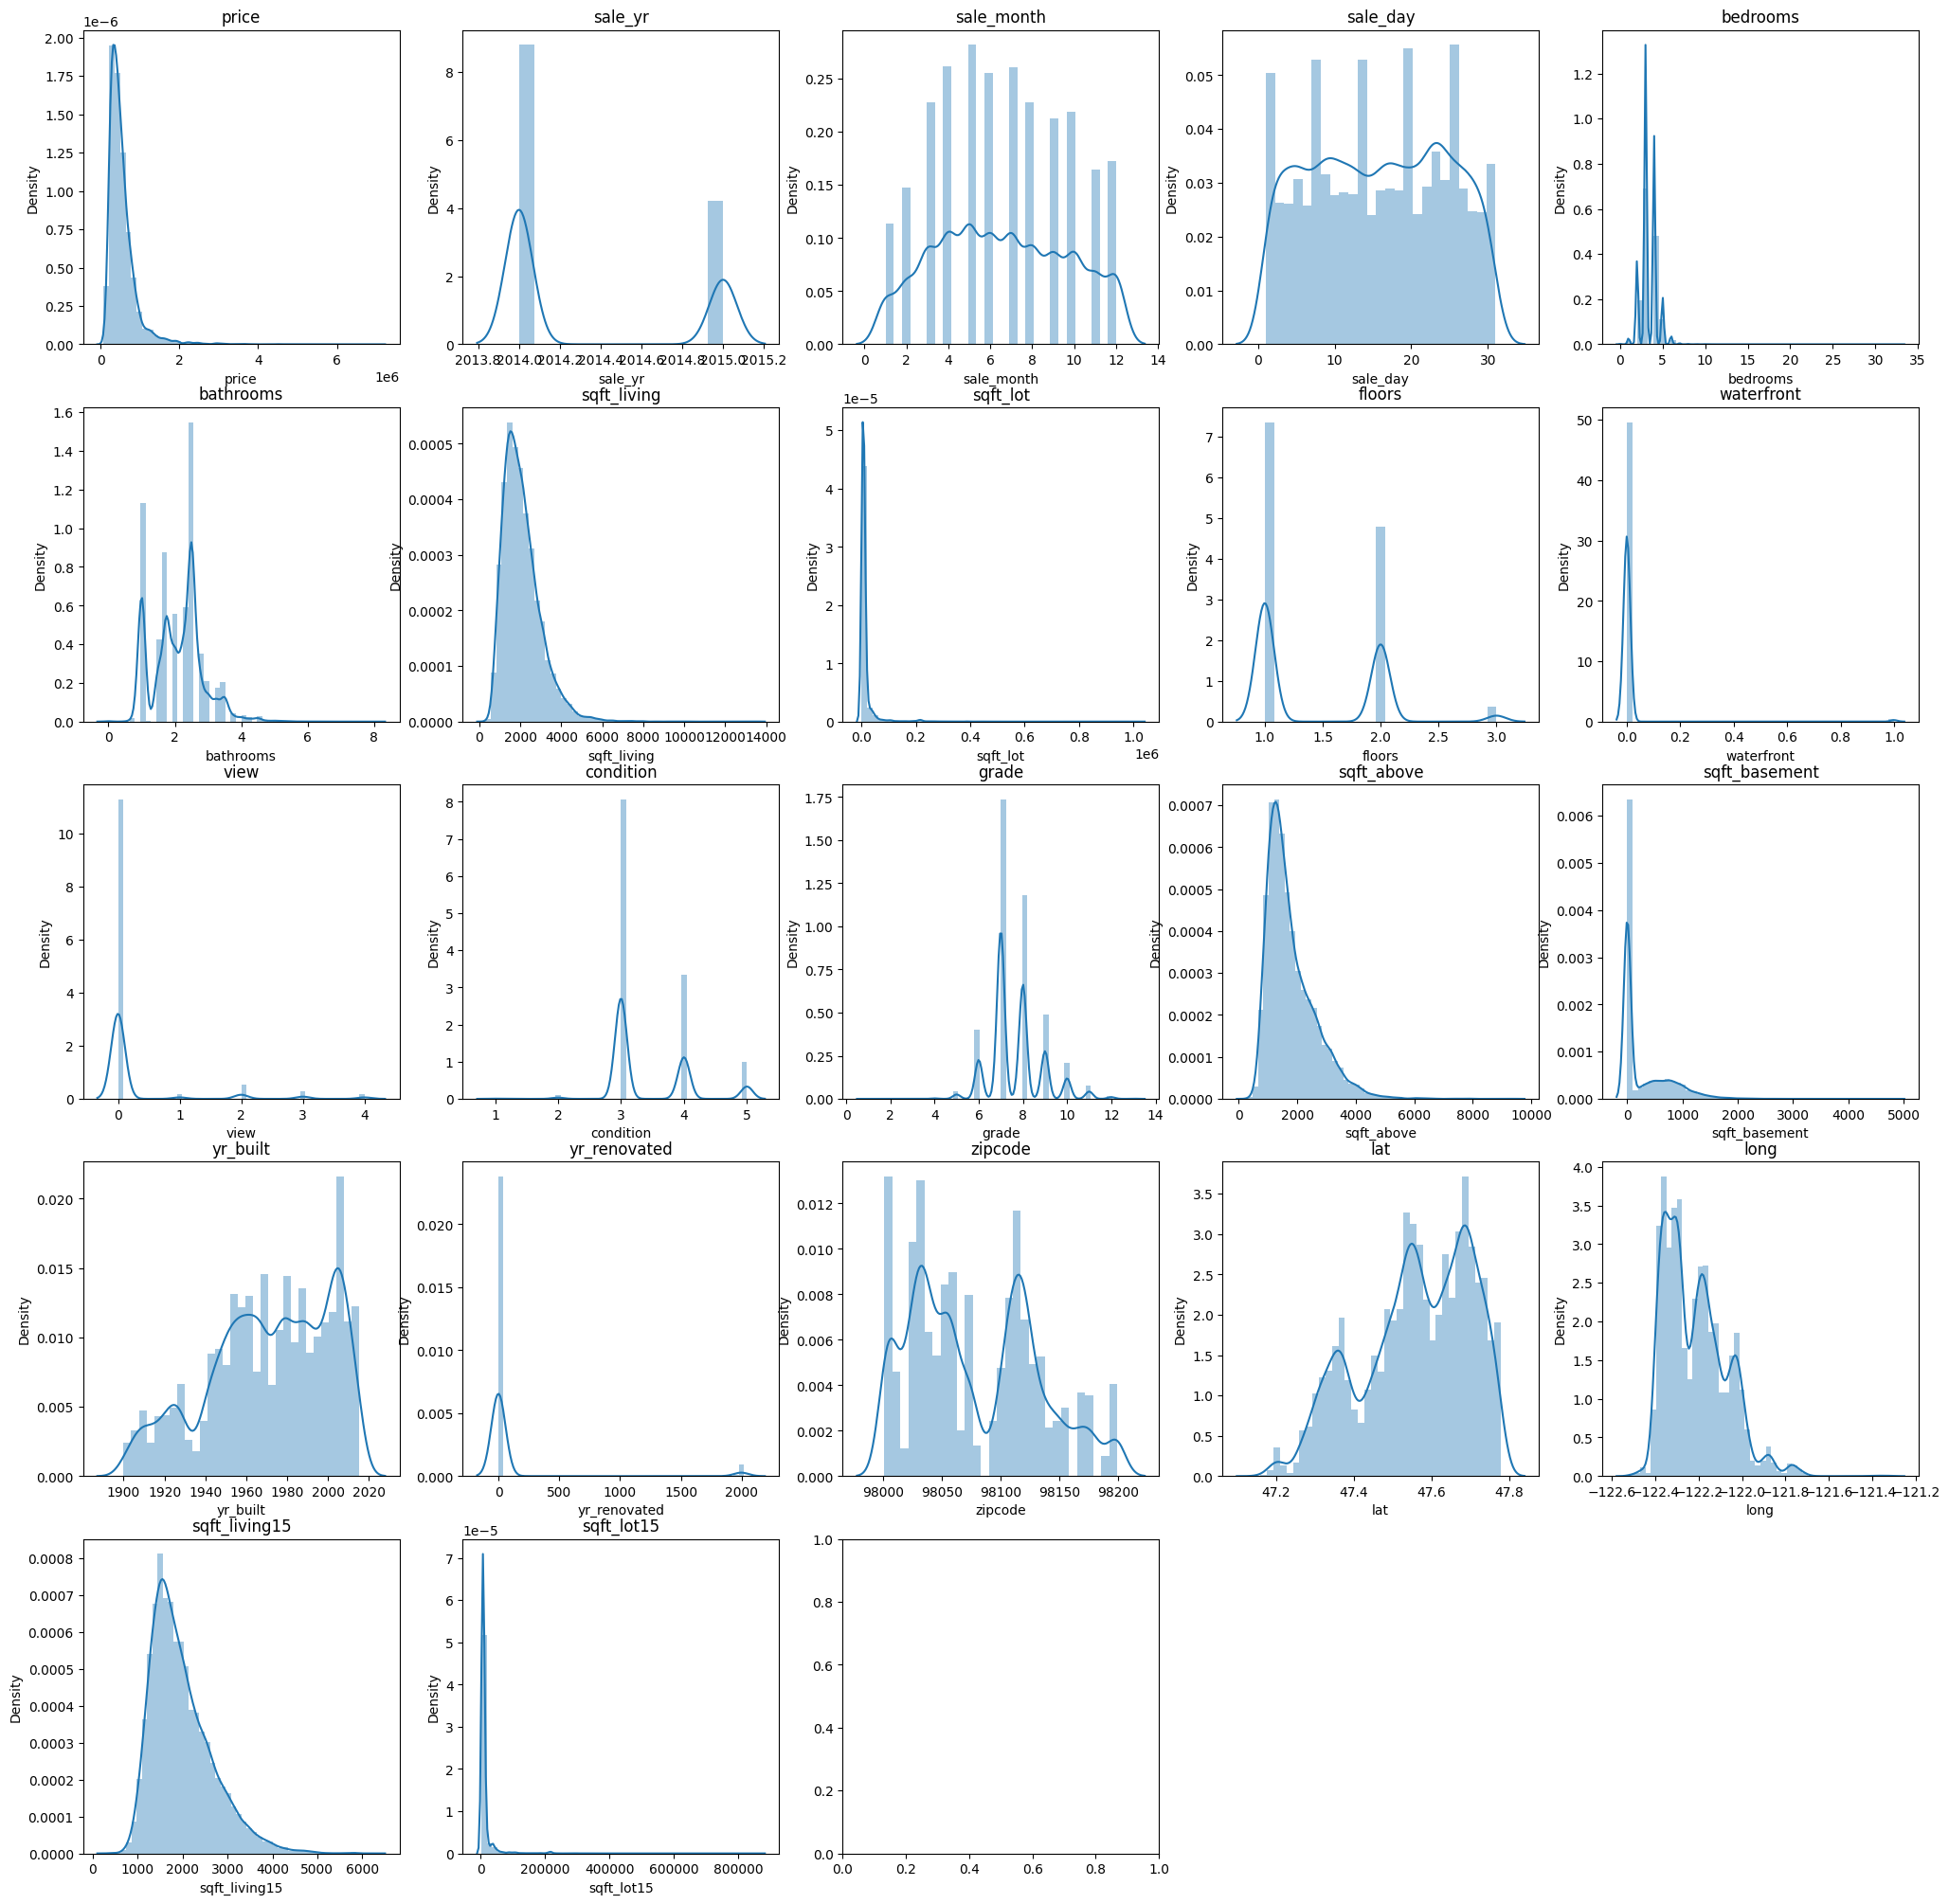

In [4]:
plt.figure(figsize=(25,25))
for i, name in enumerate(list(num_data.columns)):
    
    sns.distplot(num_data[name].dropna()).set_title(name)
    plt.subplot(5,5,i+1)

plt.show()

(array([0.5]), [Text(0, 0.5, 'price')])

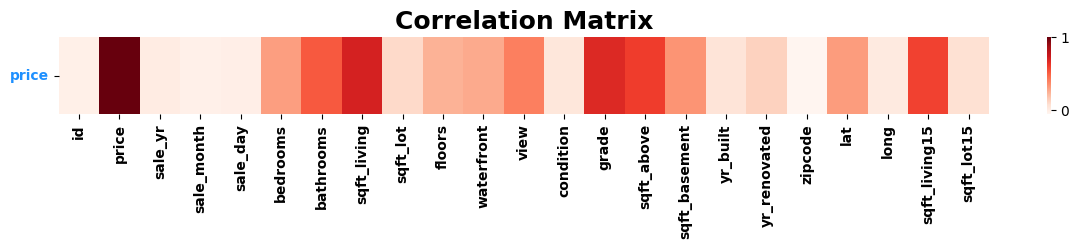

In [6]:
num_train=data_train
num_corr=num_train.corr().drop('id')    
fig,ax=plt.subplots(figsize=(15,1))
sns.heatmap(num_corr.sort_values(by=['price'], ascending=False).head(1), cmap='Reds')
plt.title("Correlation Matrix", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

In [5]:
ss_X = StandardScaler()
ss_y = StandardScaler()
def data_processing(data):
    # time data transform
    from datetime import datetime
    # print(data)
    date = data.apply(lambda row: datetime(int(row['sale_yr']), int(row['sale_month']), int(row['sale_day'])), axis=1)
    data['date_numeric'] = date.apply(lambda x: x.timestamp())
    data.drop(["sale_yr"], inplace = True, axis = 1)


    import numpy as np
    log = ['sqft_living','sqft_above', 'sqft_living15']
    for l in log:
        data[l] = np.log(data[l])


#     zero processing
    zero = ['sqft_lot', 'sqft_basement','sqft_lot15']
    for z in zero: 
        data[z] = (data[z] != 0).astype(int)

    #drop lat and long
    data.drop(["id", "sale_day", "zipcode", "condition"], inplace = True, axis = 1)

    num_vars = [c for c in data.columns if c != 'price']
    data[num_vars] = ss_X.fit_transform(data[num_vars])
    data['price'] = ss_y.fit_transform(data['price'].values.reshape(-1,1))
    
    return data


In [6]:
data_all = data_processing(pd.concat([data_train, data_valid]))
data_all

,price,sale_month,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,date_numeric
0,-0.924935,-1.145117,0.678547,-0.140981,0.009804,0.0,-0.799332,-0.089043,-0.304432,-0.551686,0.373629,-0.803381,0.139253,-0.209312,-2.497874,1.616567,-1.164045,0.0,1.313864
1,-0.512327,0.781946,0.678547,1.161667,1.365564,0.0,-0.799332,-0.089043,0.995441,0.305359,0.851190,1.244740,-0.404646,-0.209312,-0.064082,-0.329794,0.879632,0.0,-0.507995
2,-0.776396,1.745478,-0.388064,-0.140981,0.211501,0.0,-0.799332,-0.089043,-0.304432,-0.551686,-0.259073,1.244740,-0.064709,-0.209312,-1.800144,-1.143726,-0.426108,0.0,0.376403
3,-0.993703,-0.823940,-0.388064,-1.443629,-1.171949,0.0,-0.799332,-0.089043,-0.304432,-1.408731,-0.801679,-0.803381,-0.948546,-0.209312,-1.239660,-0.018376,-0.696172,0.0,1.614559
4,0.227618,-1.145117,-0.388064,0.510343,0.177140,0.0,1.010079,-0.089043,-0.304432,0.305359,0.540052,-0.803381,0.547178,-0.209312,0.091847,1.368848,0.447459,0.0,1.349239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,0.541200,0.460769,-0.388064,0.510343,0.311672,0.0,1.010079,-0.089043,-0.304432,1.162404,0.673849,-0.803381,0.615165,-0.209312,0.806104,0.512450,1.496689,0.0,-0.702562
2157,-0.168486,-1.145117,0.678547,0.510343,0.177140,0.0,1.010079,-0.089043,-0.304432,0.305359,0.540052,-0.803381,0.887115,-0.209312,1.276048,1.814742,0.916049,0.0,1.136984
2158,-0.443559,0.460769,-0.388064,0.510343,-0.515400,0.0,1.010079,-0.089043,-0.304432,-0.551686,-0.148710,-0.803381,0.615165,-0.209312,1.171856,0.370896,-0.599503,0.0,-0.631810
2159,-0.759892,-0.181586,0.678547,0.510343,0.130531,0.0,1.010079,-0.089043,-0.304432,0.305359,0.493697,-0.803381,0.615165,-0.209312,-1.575232,1.014965,0.742262,0.0,-1.135917


## Simple NN

In [7]:
class config:
    
    # root = "/kaggle/input/mia-hw1/hwk 01"
    batch_size = 64
    lr = 1e-2
    epochs = 100
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    

In [8]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
class HousingDataset(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
    def __getitem__(self, index):
        vars, price = self.df.iloc[index, 1:].to_numpy(), self.df.iloc[index, 0]
        vars, price = torch.tensor(vars), torch.tensor(price)
        
        return vars, price
    def __len__(self):
        return self.df.shape[0]
    

In [10]:
class NNRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(NNRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [11]:
def evaluate(ground_truth, prediction):
    prediction = torch.cat(prediction)
    ground_truth = torch.cat(ground_truth)

    prediction = prediction.cpu().detach().numpy()
    ground_truth = ground_truth.cpu().detach().numpy()

    prediction = ss_y.inverse_transform(prediction.reshape(-1,1))
    ground_truth = ss_y.inverse_transform(ground_truth.reshape(-1,1))

    mae = mean_absolute_error(ground_truth, prediction)

    return mae

In [12]:
def train(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    prediction = []
    ground_truth = []
    for vars, price in train_loader:
        vars = vars.to(device, dtype = torch.float)
        price = price.to(device, dtype = torch.float)

        optimizer.zero_grad()
        predict = model(vars).flatten()

        loss = criterion(price, predict)
        loss.backward()

        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        prediction.append(predict)
        ground_truth.append(price)
    
    train_loss /= len(train_loader)
    
    # prediction = torch.cat(prediction)
    # ground_truth = torch.cat(ground_truth)

    # prediction = prediction.cpu().detach().numpy()
    # ground_truth = ground_truth.cpu().detach().numpy()

    # prediction = ss_y.inverse_transform(prediction.reshape(-1,1))
    # ground_truth = ss_y.inverse_transform(ground_truth.reshape(-1,1))

    
    # mae = mean_absolute_error(ground_truth, prediction)
    
    return train_loss, evaluate(ground_truth, prediction)

In [13]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    val_loss = .0
    prediction = []
    ground_truth = []
    for vars, price in valid_loader:
        vars = vars.to(device, dtype = torch.float)
        price = price.to(device, dtype = torch.float)

        predict = model(vars).flatten()
        loss = criterion(price, predict)

        val_loss += loss.item()
        prediction.append(predict)
        ground_truth.append(price)
    
    val_loss /= len(valid_loader)
    # prediction = torch.cat(prediction)
    # ground_truth = torch.cat(ground_truth)

    # prediction = prediction.cpu().detach().numpy()
    # ground_truth = ground_truth.cpu().detach().numpy()

    # prediction = ss_y.inverse_transform(prediction.reshape(-1,1))
    # ground_truth = ss_y.inverse_transform(ground_truth.reshape(-1,1))

    
    # mae = mean_absolute_error(ground_truth, prediction)
    
    return val_loss, evaluate(ground_truth, prediction)


In [14]:
seed_everything(42)
dataset = HousingDataset(data_all)
n = data_all.shape[0]
train_indices, test_indices = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size=int(0.2*n),
        random_state=42,
)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

criterion = nn.L1Loss()
device = config.device
model =  NNRegression(18, 12, 6, 3, 1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        epochs=config.epochs, 
        steps_per_epoch=train_loader.__len__(),
        max_lr=config.lr,
)

best_val_loss = float("inf")
history = {
    "train": {
        "loss": [],
        "MAE": []
    },
    "valid": {
        "loss": [],
        "MAE": []
    },
}

for epoch in range(config.epochs):
    train_loss, train_mae = train(model, train_loader, optimizer, scheduler, criterion, device)
    valid_loss, valid_mae = validation(model, test_loader, criterion, device)

    history["train"]["loss"].append(train_loss)
    history["valid"]["loss"].append(valid_loss)
    history["train"]["MAE"].append(train_mae)
    history["valid"]["MAE"].append(valid_mae)

    print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f} Train MAE: {train_mae}| Valid Loss: {valid_loss:.4f} Valid MAE: {valid_mae}| LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

    if valid_loss < best_val_loss:
        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch,
            "args": config
        }
        best_val_loss = valid_loss
        torch.save(save_file, "checkpoint.pth")

    best_ckpt = torch.load("checkpoint.pth", map_location=device)
    model.load_state_dict(best_ckpt["model"])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(config.epochs), history["train"]["MAE"], label='Training MAE')
plt.plot(range(config.epochs), history["valid"]["MAE"], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation MAE Curves')
plt.show()

Epoch[1/100], Train Loss: 0.6265 Train MAE: 227746.71875| Valid Loss: 0.6101 Valid MAE: 221802.921875| LR: 0.000426
Epoch[2/100], Train Loss: 0.6040 Train MAE: 219592.9375| Valid Loss: 0.6101 Valid MAE: 221800.625| LR: 0.000505
Epoch[3/100], Train Loss: 0.6041 Train MAE: 219598.125| Valid Loss: 0.6101 Valid MAE: 221804.203125| LR: 0.000635
Epoch[4/100], Train Loss: 0.6041 Train MAE: 219612.0625| Valid Loss: 0.6101 Valid MAE: 221804.359375| LR: 0.000815
Epoch[5/100], Train Loss: 0.6042 Train MAE: 219633.75| Valid Loss: 0.6101 Valid MAE: 221798.359375| LR: 0.001043
Epoch[6/100], Train Loss: 0.4761 Train MAE: 173083.859375| Valid Loss: 0.2938 Valid MAE: 106814.15625| LR: 0.001317
Epoch[7/100], Train Loss: 0.2820 Train MAE: 102504.4453125| Valid Loss: 0.2708 Valid MAE: 98443.421875| LR: 0.001633
Epoch[8/100], Train Loss: 0.2635 Train MAE: 95777.1328125| Valid Loss: 0.2581 Valid MAE: 93836.640625| LR: 0.001988
Epoch[9/100], Train Loss: 0.2605 Train MAE: 94702.03125| Valid Loss: 0.2516 Valid

In [13]:
model.load_state_dict(best_weights)
data_test = pd.read_csv("ntut-ml-regression-2021/test-v3.csv")
test = data_processing(data_test)
ss_X = StandardScaler()
test[num_vars] = ss_X.fit_transform(test[num_vars])

test = torch.tensor(np.array(test), dtype=torch.float32)
nn_predict = model(test)
nn_predict = ss_y.inverse_transform(nn_predict.detach().numpy())
nn_predict = pd.DataFrame(nn_predict, columns = ['price'])
nn_predict.index += 1
pd.DataFrame(nn_predict).to_csv("Submission_nn.csv", index_label='id')

NameError: name 'ss_y' is not defined

## XGBoost

In [15]:
import xgboost as xgb
import lightgbm as lgb

In [16]:
params_xgb = {'lambda': 0.7044156083795233, 'alpha': 9.681476940192473, 'colsample_bytree': 0.3, 'subsample': 0.8,
           'learning_rate': 0.015, 'max_depth': 3, 'min_child_weight': 235,'random_state': 48,'n_estimators': 30000}

params_lgb = {'reg_alpha': 4.973064761998367, 'reg_lambda': 0.06365096912006087,'colsample_bytree': 0.24,
              'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 100, 'num_leaves': 43,'min_child_samples': 141,
              'cat_smooth': 18,'metric': 'rmse', 'random_state': 48,'n_estimators': 40000}

In [17]:
X_train

tensor([[ 1.4494, -1.1494,  0.6775,  ...,  1.6271, -1.0243,  0.0000],
        [-0.6900,  0.7813,  0.6775,  ..., -0.3306,  0.7605,  0.0000],
        [-0.6900,  1.7466, -0.3851,  ..., -1.1492, -0.5122,  0.0000],
        ...,
        [ 1.4494, -0.5059, -1.4477,  ..., -0.4089, -1.2730,  0.0000],
        [-0.6900, -0.1841, -0.3851,  ...,  1.5345, -0.5122,  0.0000],
        [-0.6900, -0.5059, -0.3851,  ..., -0.9712, -0.6878,  0.0000]])

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# 建立 XGBClassifier 模型
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 72912.252 (1410.653)


In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# 建立 XGBClassifier 模型
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 72912.252 (1410.653)


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# 建立 XGBClassifier 模型
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X_train, y_train)
yhat = model.predict(X_test)

Mean MAE: 72912.252 (1410.653)


In [21]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, yhat)
print("MAE:", mae)

MAE: 77251.32


In [22]:
model = lgb.LGBMRegressor()
# define model evaluation method
model.fit(X_train, y_train)
yhat = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 12967, number of used features: 16
[LightGBM] [Info] Start training from score 537383.289041


In [23]:
mae = metrics.mean_absolute_error(y_test, yhat)
print("MAE:", mae)

MAE: 66208.41967188736
